In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import utils, optimization, metrics, plot
import pickle

# Parameters

In [3]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [4]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [5]:
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [6]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

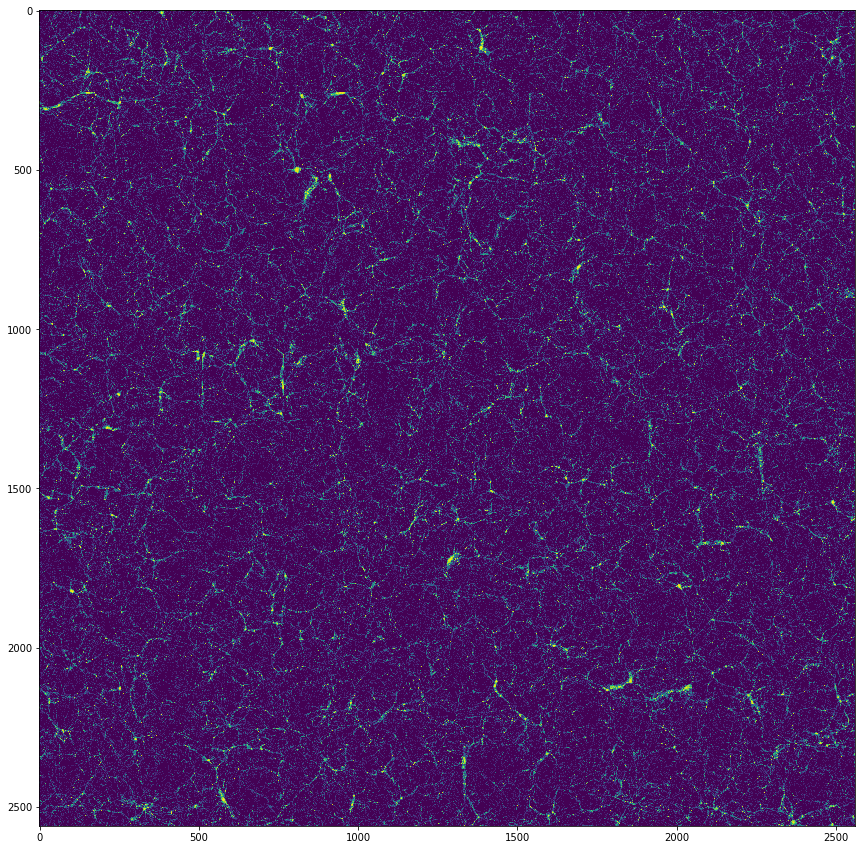

In [7]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

Let us make small patches of 64 :-)

In [8]:
ns = 64
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        l = j + i*cut 
        img_small[l*nsamples:(l+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

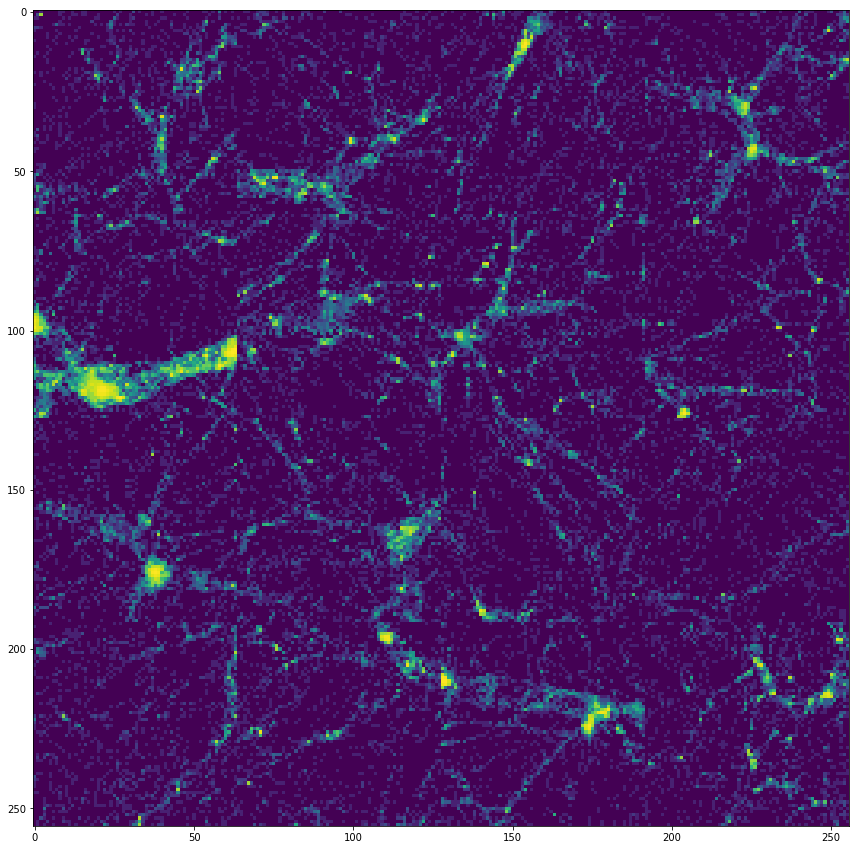

In [9]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=4,ny=4,px=ns,py=ns)

# A) Train a small GAN

In [10]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str() 
global_path = '../../saved_result/'


In [105]:
up_scaling = 2
latent_dim = (ns//up_scaling)**2
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2,2 , 1]
params_discriminator['nfilter'] = [16, 128, 256, 128, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [3, 3], [3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [1, 1, 2, 1, 1]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [64, 256, 128 ,64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn, bn, bn]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'
params_generator['upsampling'] = up_scaling
params_generator['encoder'] = params_encoder

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['weight_l2'] = 0.1
params_optimization['batch_size'] = 16
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 3e-4
params_optimization['gen_learning_rate'] = 3e-4
params_optimization['beta1'] = 0.0
params_optimization['beta2'] = 0.9
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 50

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['encoder'] = params_encoder
params['optimization'] = params_optimization

params['image_size'] = [ns, ns]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
params['name'] = 'LAPWGAN{}'.format(ns)
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + 'checkpoints/'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['k'] = k





In [ ]:
from model import LapGanModel
from gan import GAN

obj = GAN(params, LapGanModel)

Generator 
------------------------------------------------------------
     The input X is of size (?, 32, 32, 1)
     The input z is of size (?, 1024)
     Reshape z to (?, 32, 32, 1)
     Concat x and z to (?, 32, 32, 2)
     0 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 32, 32, 64)
     1 Deconv layer with 256 channels
         Batch norm
         Size of the variables: (?, 32, 32, 256)
     2 Deconv layer with 128 channels
         Batch norm
         Size of the variables: (?, 64, 64, 128)
     3 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 64, 64, 64)
     4 Deconv layer with 1 channels
         Size of the variables: (?, 64, 64, 1)
    Non lienarity: tanh
     The output is of size (?, 64, 64, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 64, 64, 2)
     0 Conv layer with 1

In [ ]:
obj.train(img_small)

Erease recursively directory: ../../saved_result/LAPWGAN64_2018_1_15_15_30summary/
Epoch: [ 0] [  99/15000] Counter:100	( 0.4 min	60.35 examples/sec	0.265 sec/batch)	L_Disc:-2.10135174	L_Gen:-4.35264206
Epoch: [ 0] [ 199/15000] Counter:200	( 0.9 min	62.80 examples/sec	0.255 sec/batch)	L_Disc:-1.46411753	L_Gen:-1.64321840
 [*] [Fake, Real] Min [0.107, 0.146],	Median [1.422,0.779],	Mean [1.911E+04,2.129E+00],	 Max [3.196E+06,1.278E+02],	 Var [8.522E+10,5.851E+01]
 [*] [Comp, Fake, Real] PeakDistance:[4.554, 1.429, 0.161]	CrossPS:[12.788, 95.126, 12.384]	PSD_Diff:13123746.867
 [*] New PSD Low achieved 30355750.570533 (was 10000000000.000000)
 [*] New Log PSD Low achieved 70.410028 (was 10000.000000)
 200 current PSD L2 30355750.57053281, logL2 70.410028293121
Epoch: [ 0] [ 299/15000] Counter:300	( 1.4 min	52.33 examples/sec	0.306 sec/batch)	L_Disc:-0.67793417	L_Gen:-4.27139473


In [ ]:

gen_sample, gen_sample_raw = obj.generate()
        

In [ ]:
import plot

plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = [0,0.5,1])
